In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

In [5]:
stock_objects = context.catalog.load('primary_parts_ETF_stock_objects')

2021-07-29 22:20:59,661 - kedro.io.data_catalog - INFO - Loading data from `primary_parts_ETF_stock_objects` (PartitionedDataSet)...


C:\ProgramData\Anaconda3\envs\investing\lib\site-packages\kedro\framework\context\context.py:469: UserWarning: Credentials not found in your Kedro project config.
No files found in ['C:\\Users\\rick-\\OneDrive\\Projects\\Investing\\Sandbox\\Investing\\conf\\base', 'C:\\Users\\rick-\\OneDrive\\Projects\\Investing\\Sandbox\\Investing\\conf\\local'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [4]:
AGBP = stock_objects['AGBP.LON']()
HMCX = stock_objects['HMCX.LON']()
ISF  = stock_objects['ISF.LON']()

<AxesSubplot:>

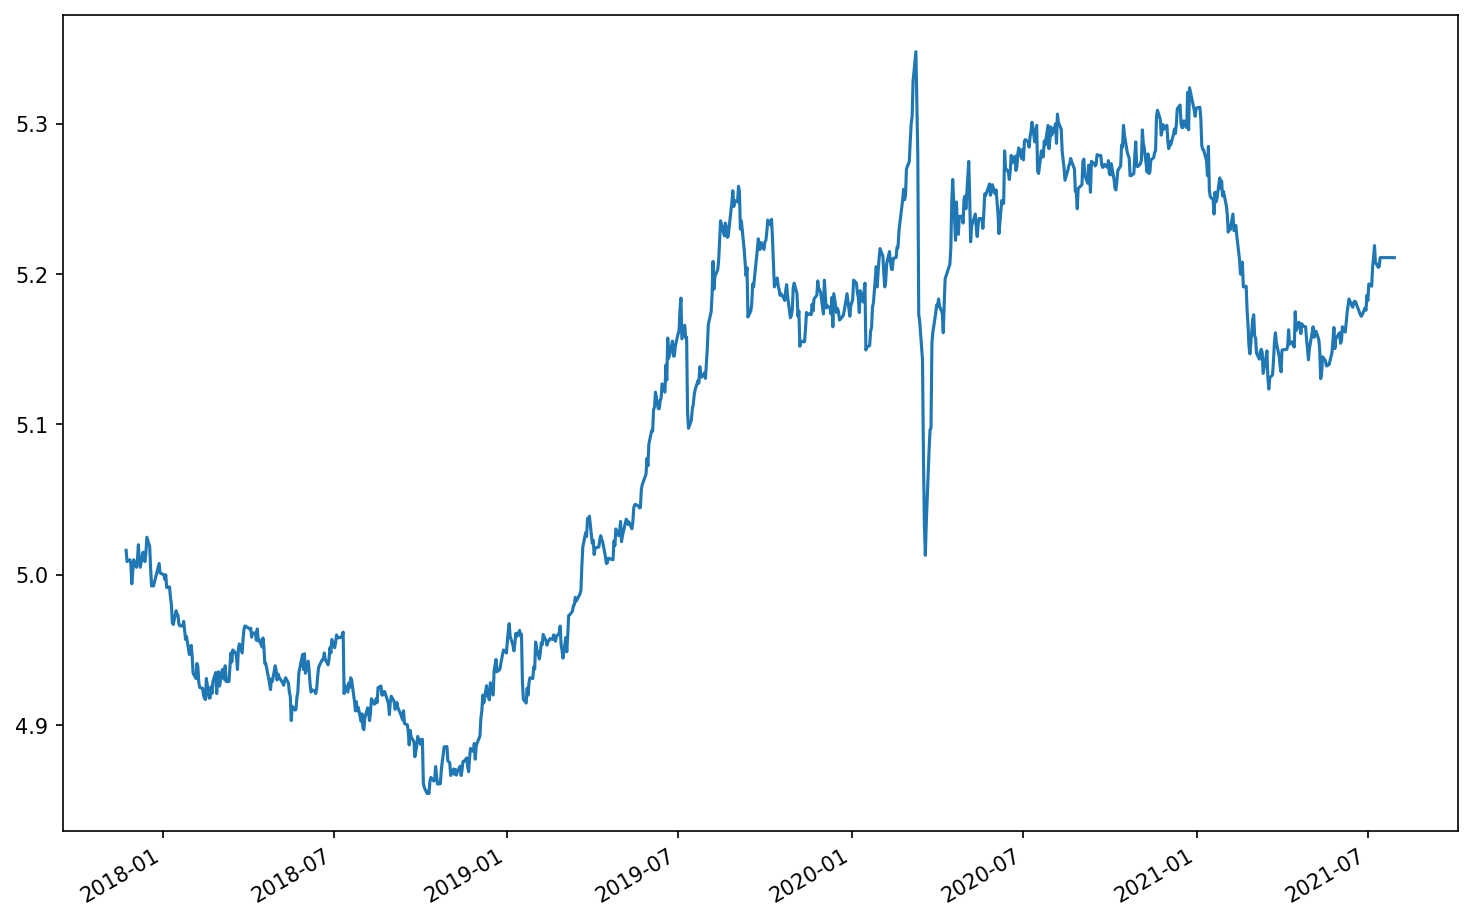

In [5]:
AGBP.time_series['close'].plot()

In [6]:
AGBP.daily_change

2017-11-24   -0.001495
2017-11-27    0.000240
2017-11-28   -0.000499
2017-11-29   -0.002696
2017-11-30    0.001702
                ...   
2021-07-08    0.001535
2021-07-09   -0.002108
2021-07-12   -0.000672
2021-07-13    0.000096
2021-07-14    0.001153
Name: change, Length: 918, dtype: float64

In [7]:
from scipy import stats

In [8]:
def fit_distribution(custom_dates=None, attr_name=None):

    dc = AGBP.daily_change

    if custom_dates:
        dc = dc.loc[dc.index.intersection(pd.to_datetime(custom_dates))]

    print(dc)

    results = {}
    for i in AGBP.distributions:
        dist = getattr(stats, i)
        param = dist.fit(dc)
        pvalue = stats.kstest(dc, i, args=param)[1]
        results[pvalue] = dist(*param)

    best_dist = results[max(results.keys())]

    if attr_name:
        setattr(self, attr_name, best_dist)

    return best_dist


In [9]:
fit_distribution(custom_dates=['2021-01-01', '2022-01-01', '2021-04-14'])

2021-04-14   -0.000194
Name: change, dtype: float64


C:\ProgramData\Anaconda3\envs\investing\lib\site-packages\scipy\stats\_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


In [10]:
AGBP.fit_distribution(custom_dates=['2021-01-01', '2022-01-01', '2021-04-14'], attr_name='test')

In [11]:
AGBP.time_series.close

2017-11-23    5.0163
2017-11-24    5.0088
2017-11-27    5.0100
2017-11-28    5.0075
2017-11-29    4.9940
               ...  
2021-07-23    5.2110
2021-07-26    5.2110
2021-07-27    5.2110
2021-07-28    5.2110
2021-07-29    5.2110
Name: close, Length: 930, dtype: float64

<AxesSubplot:>

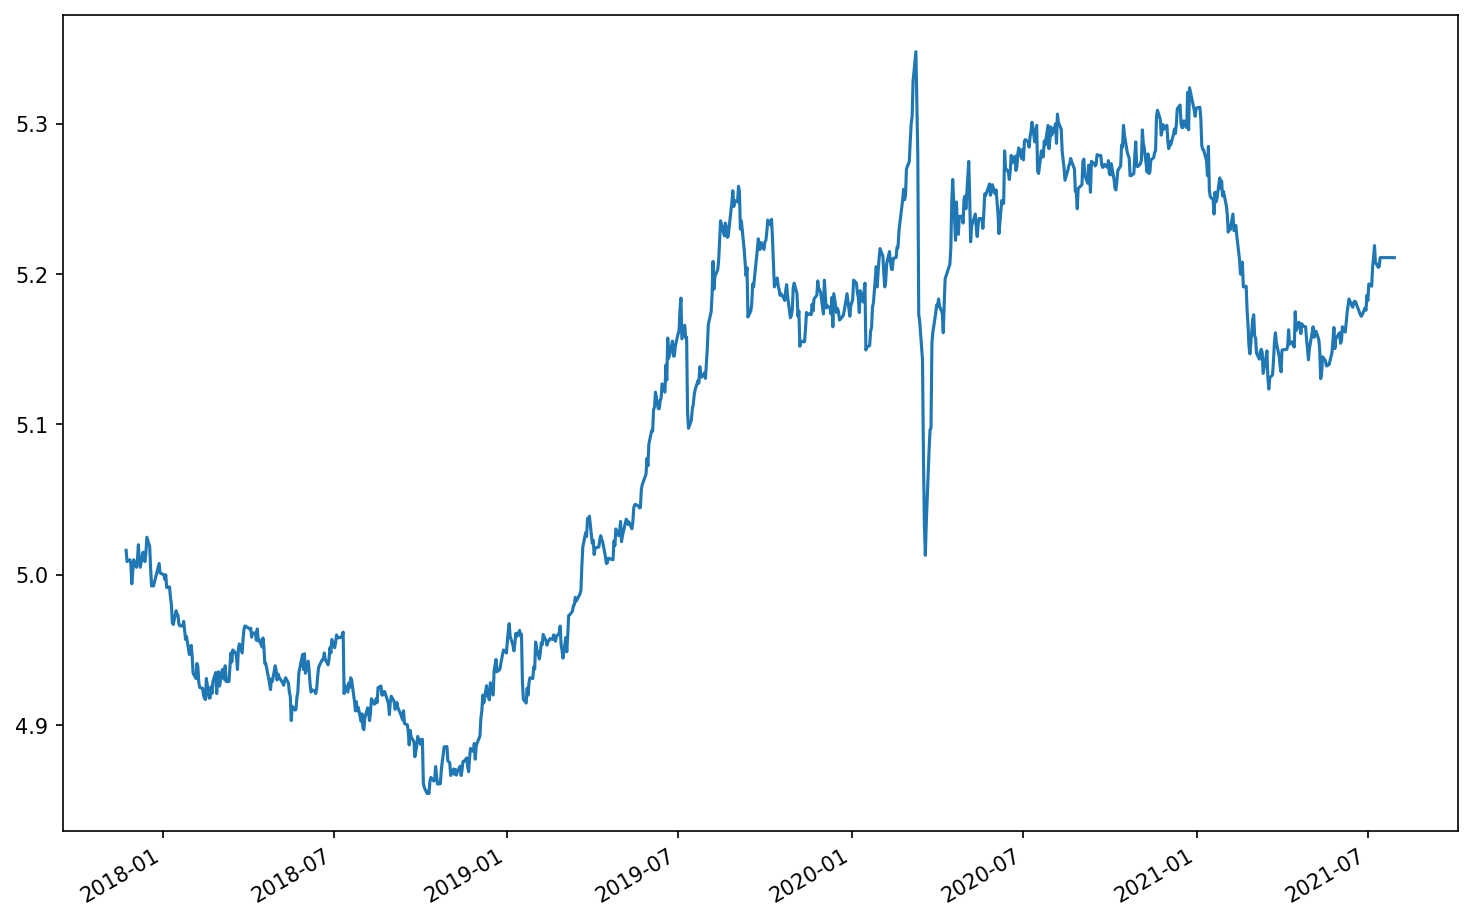

In [12]:
AGBP.time_series.close.plot()

# Develop Indicators

## TRAMA

In [13]:
# fillna
ISF.time_series.close.fillna(method='ffill', inplace=True)
ISF.time_series.close.fillna(method='bfill', inplace=True)

In [14]:
def highest_high(series, n):
    _max = series.rolling(window=n).max()
    return np.maximum(np.sign(_max - _max.shift(1)), 0)    

In [15]:
arr_hh = highest_high(ISF.time_series.close, 500).fillna(0)
arr_hh

2005-01-04    0.0
2005-01-05    0.0
2005-01-06    0.0
2005-01-07    0.0
2005-01-10    0.0
             ... 
2021-07-23    0.0
2021-07-26    0.0
2021-07-27    0.0
2021-07-28    0.0
2021-07-29    0.0
Name: close, Length: 4189, dtype: float64

In [16]:
def lowest_low(series, n):
    _min = series.rolling(window=n).min()
    return np.maximum(np.sign(_min.shift(1) - _min), 0)

In [17]:
arr_ll = lowest_low(ISF.time_series.close, 500).fillna(0)

In [18]:
arr_ll

2005-01-04    0.0
2005-01-05    0.0
2005-01-06    0.0
2005-01-07    0.0
2005-01-10    0.0
             ... 
2021-07-23    0.0
2021-07-26    0.0
2021-07-27    0.0
2021-07-28    0.0
2021-07-29    0.0
Name: close, Length: 4189, dtype: float64

In [19]:
arr1 = np.logical_or(arr_ll, arr_hh).astype('uint8')

In [20]:
tc = np.power(arr1.rolling(window=500).mean(), 2)
tc[-200:]

2020-10-14    0.000576
2020-10-15    0.000576
2020-10-16    0.000576
2020-10-19    0.000576
2020-10-20    0.000576
                ...   
2021-07-23    0.000256
2021-07-26    0.000256
2021-07-27    0.000256
2021-07-28    0.000256
2021-07-29    0.000256
Name: close, Length: 200, dtype: float64

In [21]:
ama =[]
for a, b in zip(ISF.time_series.close, tc):
    if not ama:
        nxt = a + b
    else:
        nxt = ama[-1] + b * (a - ama[-1])
    if np.isnan(nxt):
        ama.append(a)
    else:
        ama.append(nxt)


In [22]:
ISF.time_series['TRAMA500'] = ama

<AxesSubplot:>

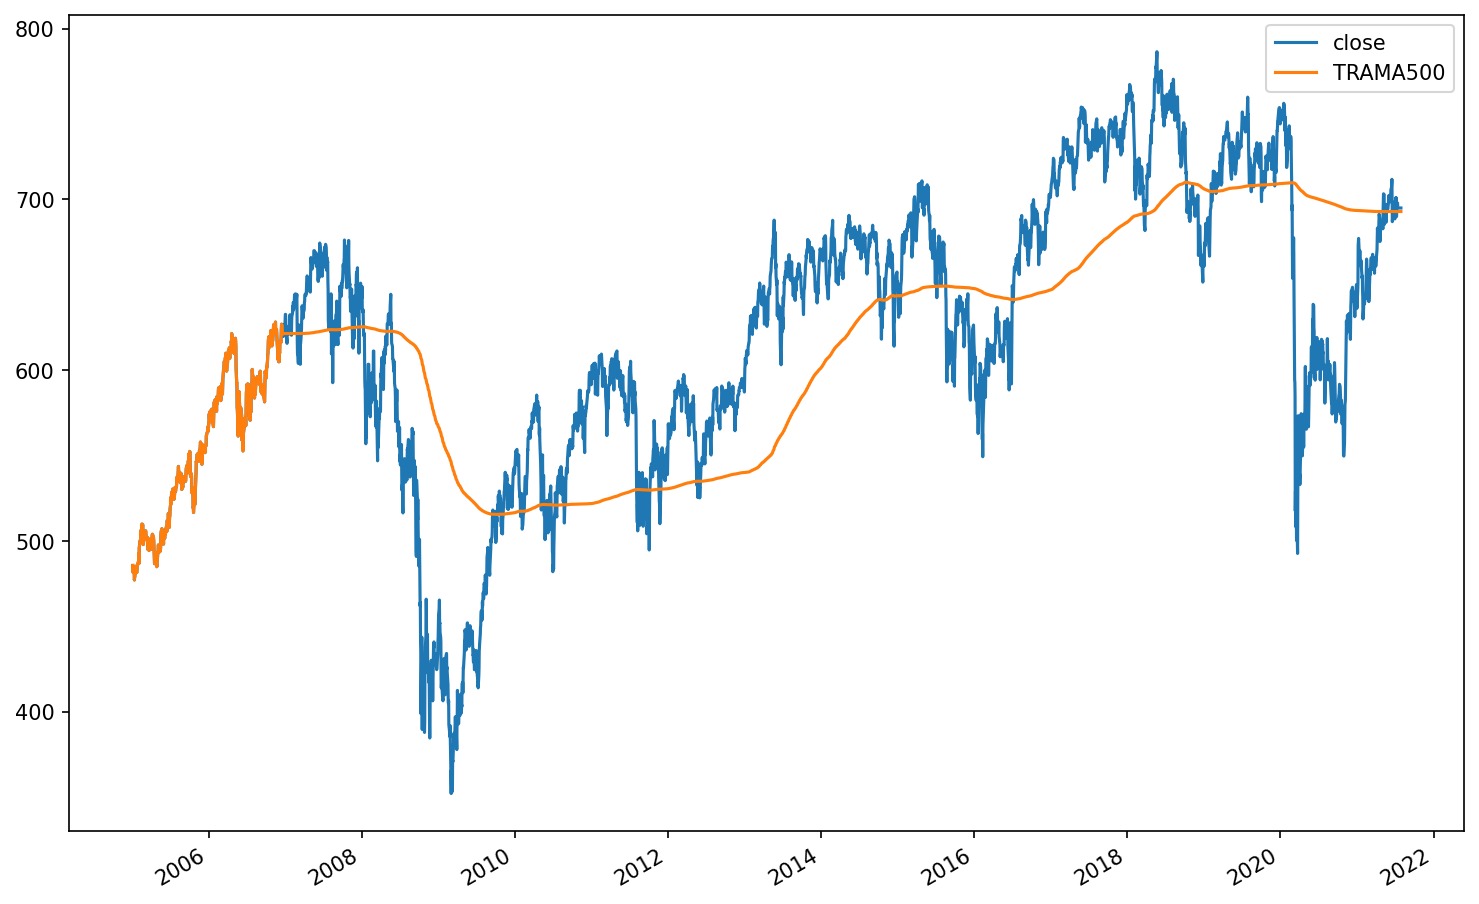

In [23]:
ISF.time_series[['close','TRAMA500']].plot()

## Hull Moving Average (HMA)

In [24]:
# fillna
HMCX.time_series.close.fillna(method='ffill', inplace=True)
HMCX.time_series.close.fillna(method='bfill', inplace=True)

In [25]:
from typing import List, Optional

def weighted_moving_average(series: List[float], lookback: Optional[int] = None) -> float:
    if not lookback:
        lookback = len(series)
    if len(series) == 0:
        return 0
    assert 0 < lookback <= len(series)

    wma = 0
    lookback_offset = len(series) - lookback
    for index in range(lookback + lookback_offset - 1, lookback_offset - 1, -1):
        weight = index - lookback_offset + 1
        wma += series[index] * weight
    return wma / ((lookback ** 2 + lookback) / 2)


def hull_moving_average(series: List[float], lookback: int) -> float:
    assert lookback > 0
    hma_series = []
    for k in range(int(lookback ** 0.5), -1, -1):
        s = series[:-k or None]
        wma_half = weighted_moving_average(s, min(lookback // 2, len(s)))
        wma_full = weighted_moving_average(s, min(lookback, len(s)))
        hma_series.append(wma_half * 2 - wma_full)
    return weighted_moving_average(hma_series)

In [26]:
hull_moving_average(list(HMCX.time_series.close), 500)

2163.11810803339

In [27]:
# or better option to use pre-built implementation
from finta import TA

In [28]:
ISF.time_series['HMA500'] = TA.HMA(ISF.time_series, 500)

<AxesSubplot:>

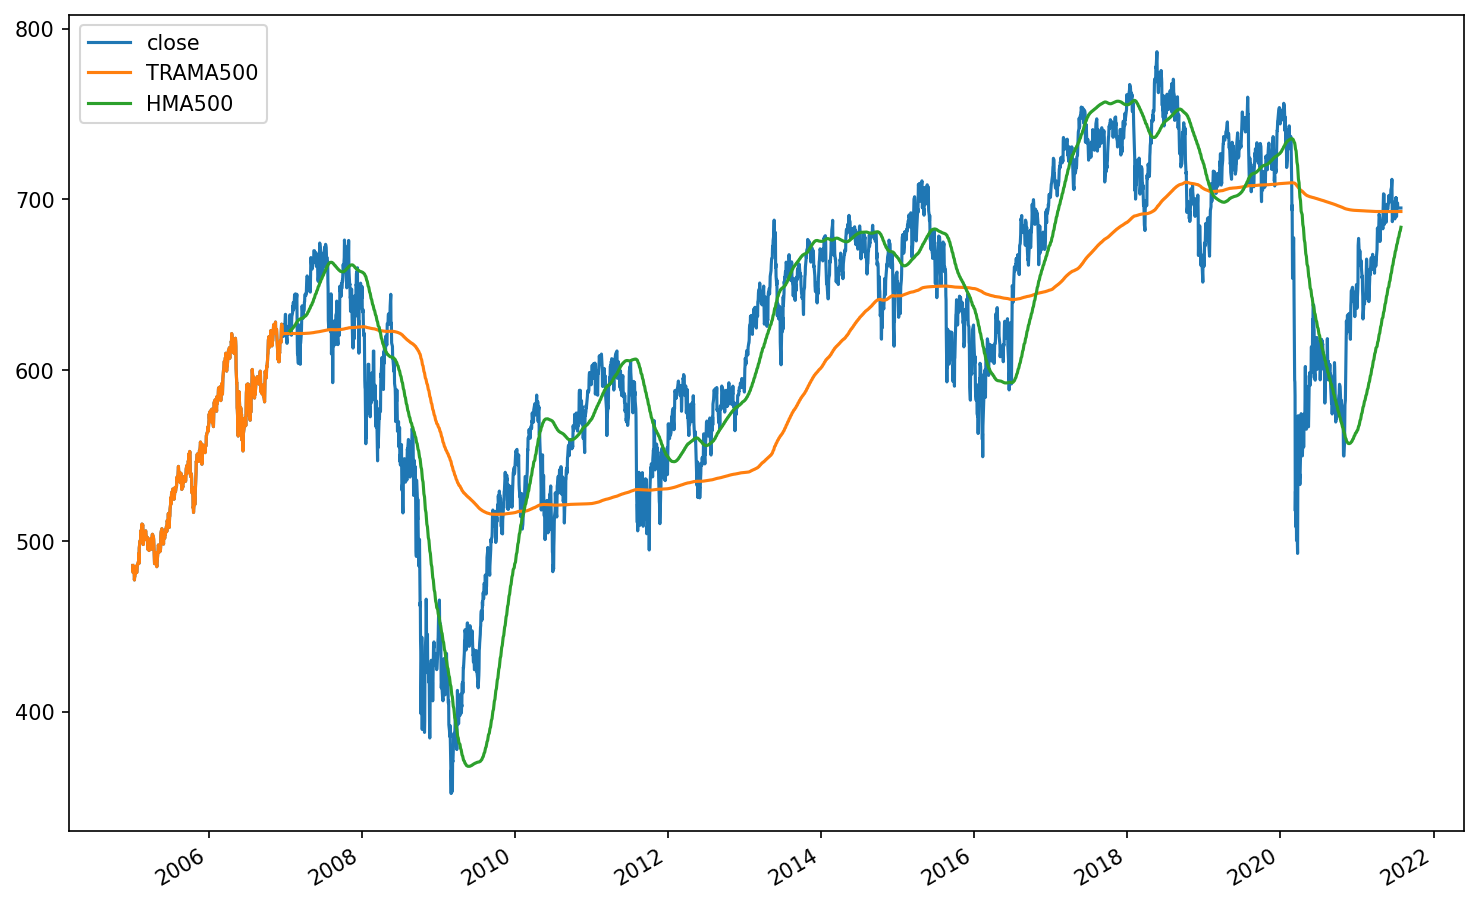

In [29]:
ISF.time_series[['close', 'TRAMA500', 'HMA500']].plot()

## build TRAMA using finta

In [30]:
from finta import TA

In [31]:
TA.test = 1

In [32]:
from investing.common.technical_indicators import TA

In [33]:
ISF.time_series['TRAMA500_TA'] = TA.TRAMA(ISF.time_series, period=500)

<AxesSubplot:>

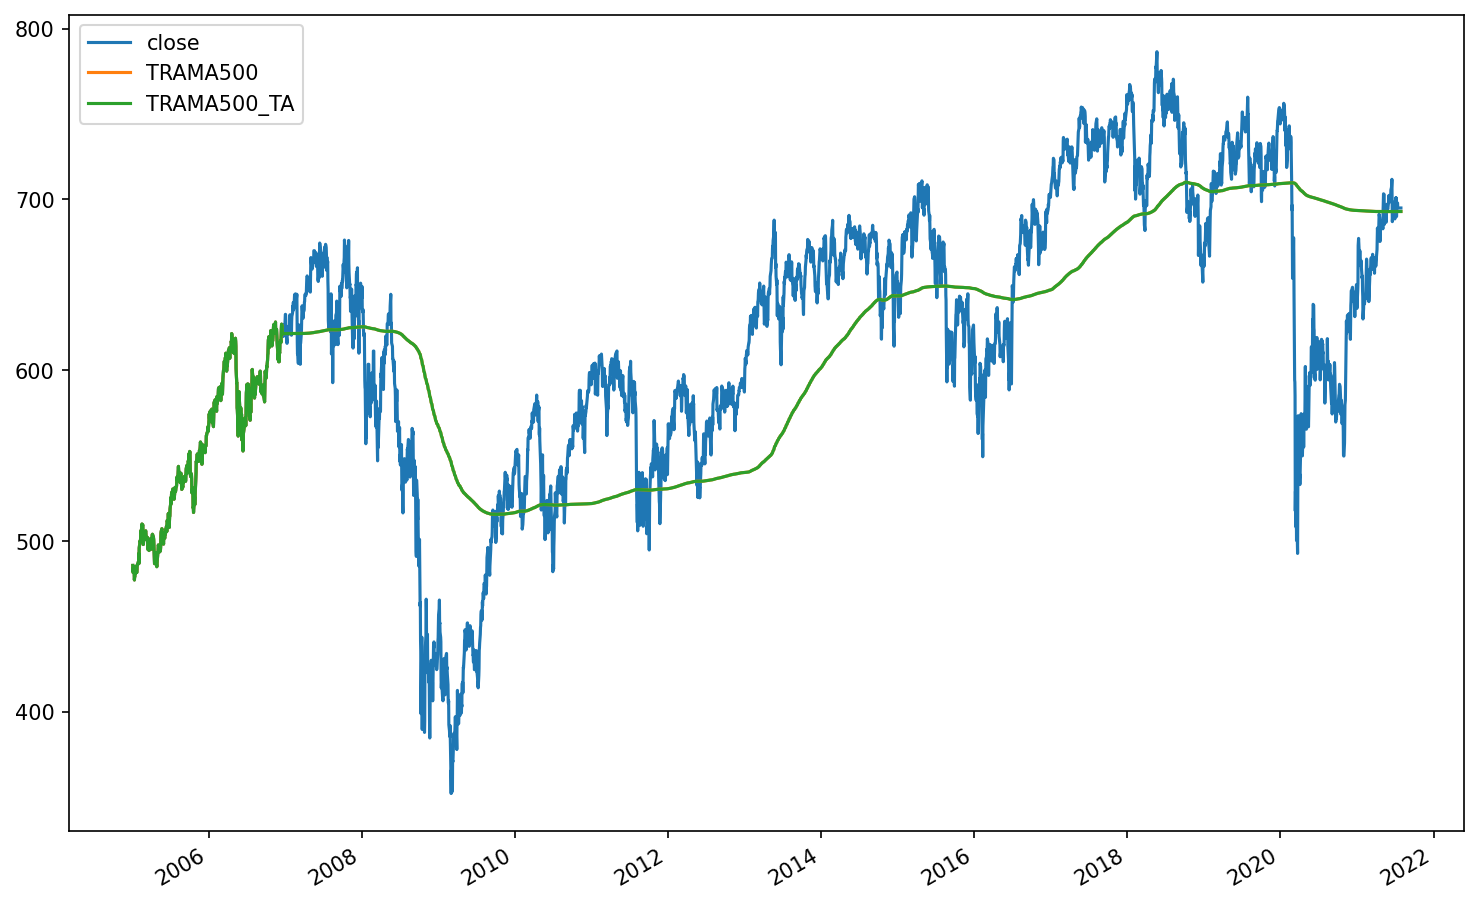

In [34]:
ISF.time_series[['close', 'TRAMA500', 'TRAMA500_TA']].plot()

In [35]:
info = context.catalog.load('raw_parts_investpy_etf_information')

2021-07-29 15:59:51,990 - kedro.io.data_catalog - INFO - Loading data from `raw_parts_investpy_etf_information` (PartitionedDataSet)...


C:\ProgramData\Anaconda3\envs\investing\lib\site-packages\kedro\framework\context\context.py:469: UserWarning: Credentials not found in your Kedro project config.
No files found in ['C:\\Users\\rick-\\OneDrive\\Projects\\Investing\\Sandbox\\Investing\\conf\\base', 'C:\\Users\\rick-\\OneDrive\\Projects\\Investing\\Sandbox\\Investing\\conf\\local'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [36]:
info['etf_ISF_IE0005042456']()['Asset Class']

'Equity'

# Testing

In [37]:
stock_objects = context.catalog.load('primary_parts_ETF_stock_objects')

2021-07-29 15:59:52,515 - kedro.io.data_catalog - INFO - Loading data from `primary_parts_ETF_stock_objects` (PartitionedDataSet)...


In [38]:
AGBP = stock_objects['AGBP.LON']()
HMCX = stock_objects['HMCX.LON']()
ISF  = stock_objects['ISF.LON']()

<AxesSubplot:>

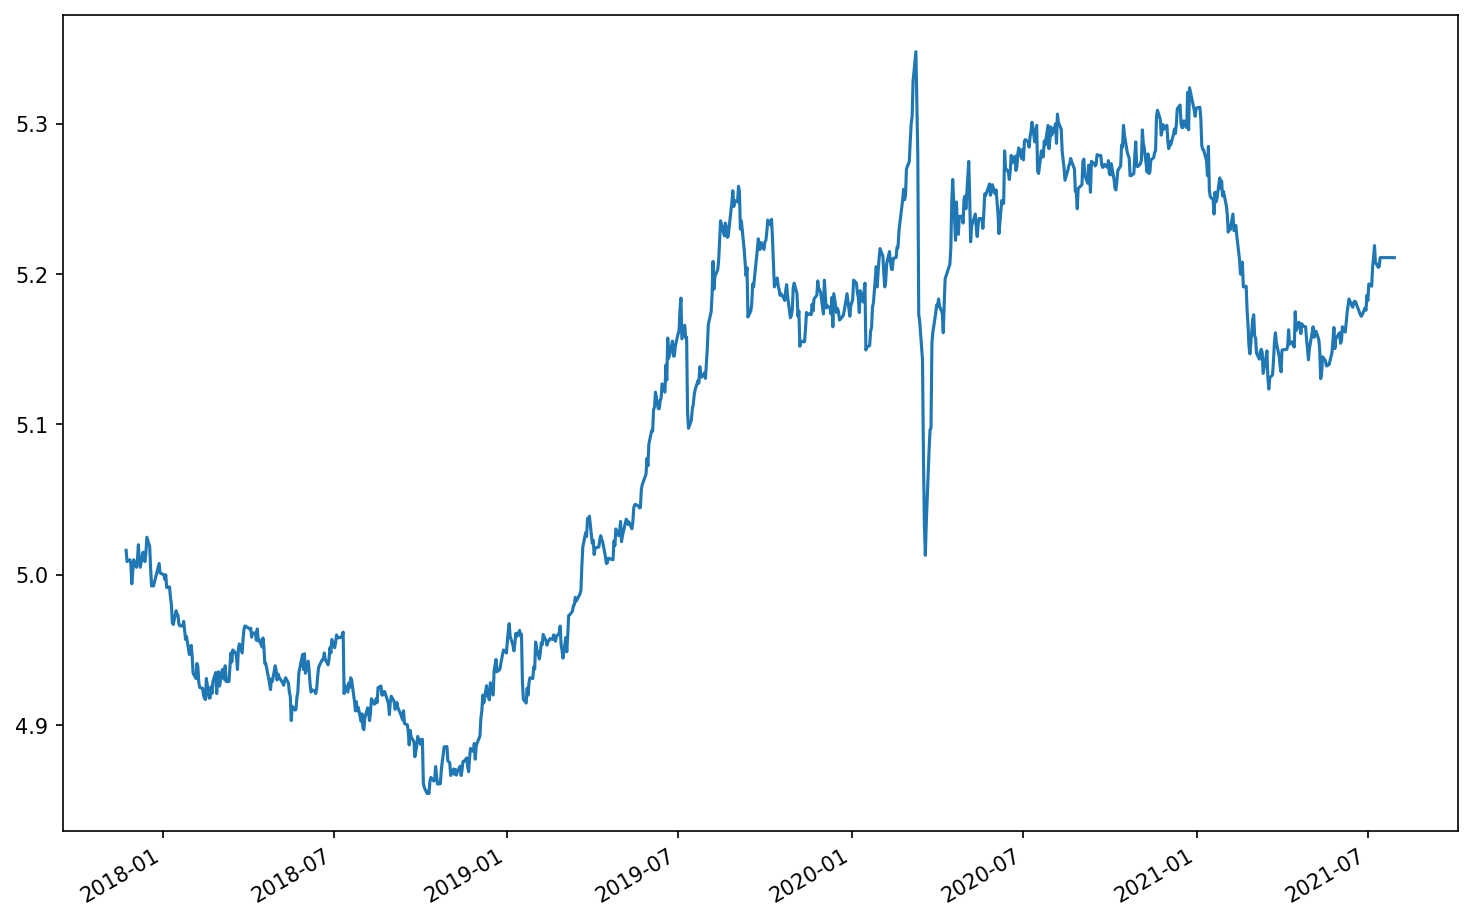

In [39]:
AGBP.time_series['close'].plot()

In [40]:
ISF.asset_class

'Equity'

In [41]:
dir(AGBP)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calculate_daily_valid_price_difference',
 '_fill_missing_time_series',
 '_load_dividends',
 '_load_historic',
 'annual_dividends',
 'apply_technical_indicator',
 'approx_next_dividend_date',
 'approx_next_dividend_pct',
 'asset_class',
 'daily_change',
 'distributions',
 'dividend_yield',
 'eng_hols',
 'fit_distribution',
 'is_dividend_upcoming',
 'latest',
 'mean_distribution_return',
 'mean_empirical_return',
 'symbol',
 'time_series',
 'today',
 'upcoming_dividend']

In [42]:
AGBP.annual_dividends

2.0

In [43]:
AGBP.daily_change

2017-11-24   -0.001495
2017-11-27    0.000240
2017-11-28   -0.000499
2017-11-29   -0.002696
2017-11-30    0.001702
                ...   
2021-07-08    0.001535
2021-07-09   -0.002108
2021-07-12   -0.000672
2021-07-13    0.000096
2021-07-14    0.001153
Name: change, Length: 918, dtype: float64

In [44]:
ISF.apply_technical_indicator('HMA', period=500)

In [45]:
ISF.apply_technical_indicator('TRAMA', period=500)

<AxesSubplot:>

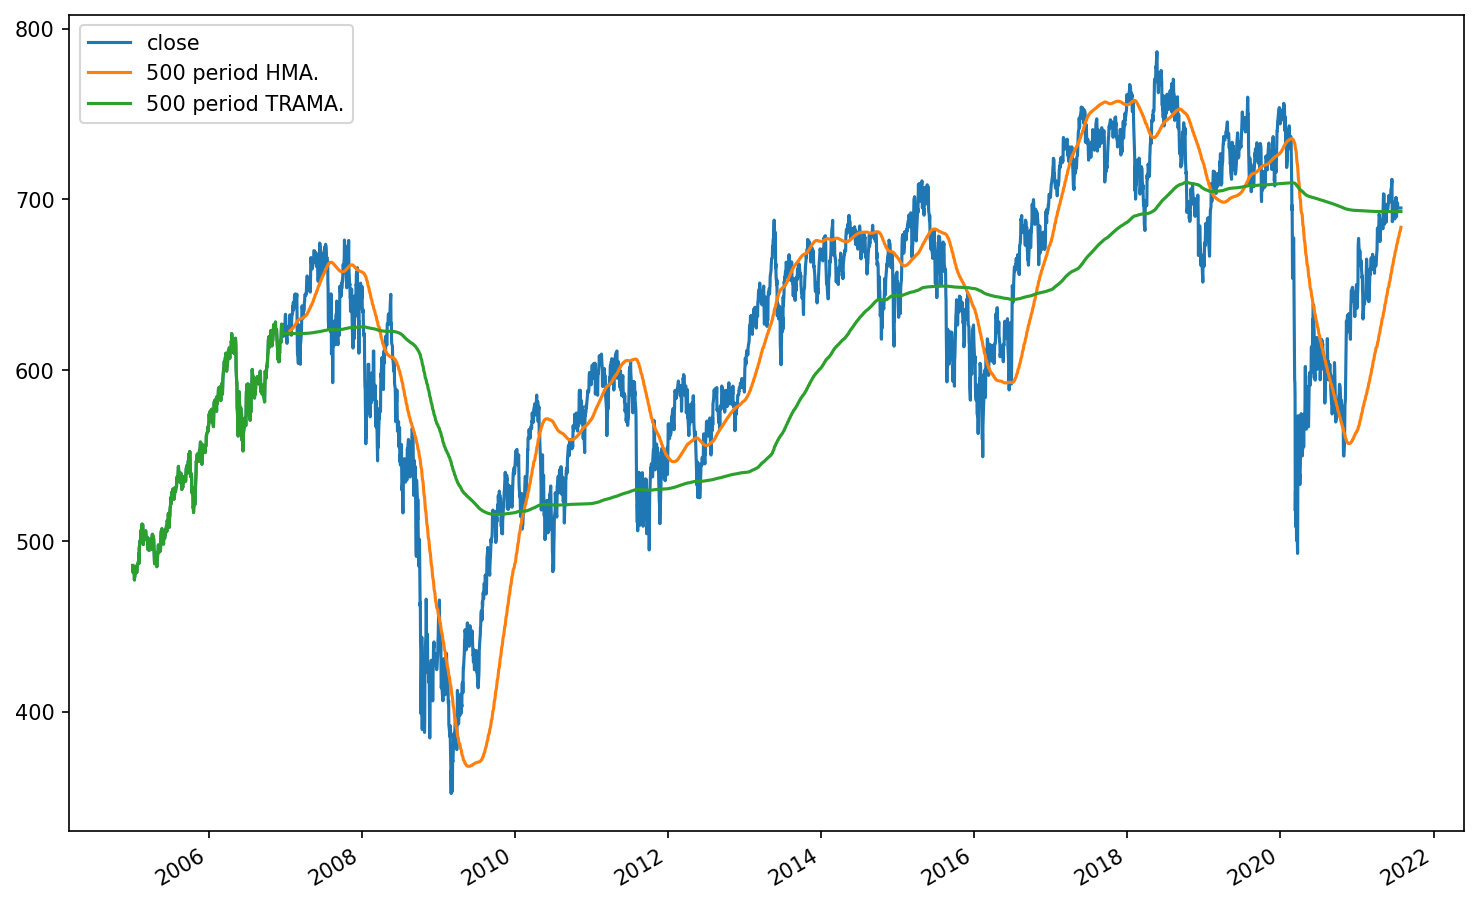

In [46]:
ISF.time_series[['close', '500 period HMA.', '500 period TRAMA.']].plot()

In [47]:
ISF.time_series['500 period TRAMA.']

2005-01-04    485.750000
2005-01-05    481.750000
2005-01-06    482.250000
2005-01-07    484.500000
2005-01-10    484.750000
                 ...    
2021-07-23    692.945977
2021-07-26    692.946503
2021-07-27    692.947028
2021-07-28    692.947554
2021-07-29    692.948079
Name: 500 period TRAMA., Length: 4189, dtype: float64

## Rate of Change (ROC)

In [48]:
ISF.apply_technical_indicator('ROC', period=1, column='500 period HMA.')

In [49]:
ISF.time_series[['500 period HMA.', 'ROC']]

,500 period HMA.,ROC
2005-01-04,NaN,NaN
2005-01-05,NaN,NaN
2005-01-06,NaN,NaN
2005-01-07,NaN,NaN
2005-01-10,NaN,NaN
...,...,...
2021-07-23,680.938201,0.104703
2021-07-26,681.643659,0.103601
2021-07-27,682.342424,0.102512
2021-07-28,683.034582,0.101439


##  Latest

In [50]:
ISF.latest('500 period HMA.')

683.7199103845818

In [51]:
ISF.latest('close')

695.0

In [52]:
ISF.latest('close') > ISF.latest('500 period HMA.')

True

## Mean expected return

In [53]:
ISF.mean_empirical_return()

1.003241021076439

## Dividends

In [54]:
dir(ISF)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calculate_daily_valid_price_difference',
 '_fill_missing_time_series',
 '_load_dividends',
 '_load_historic',
 'annual_dividends',
 'apply_technical_indicator',
 'approx_next_dividend_date',
 'approx_next_dividend_pct',
 'asset_class',
 'daily_change',
 'distributions',
 'dividend_yield',
 'eng_hols',
 'fit_distribution',
 'is_dividend_upcoming',
 'latest',
 'mean_distribution_return',
 'mean_empirical_return',
 'symbol',
 'time_series',
 'today',
 'upcoming_dividend']

In [55]:
print(ISF.annual_dividends)
print(ISF.approx_next_dividend_date)
print(ISF.approx_next_dividend_pct)
print(ISF.dividend_yield)

4.0
2021-09-17
0.0096545914069081
0.0350601414648784


In [56]:
ISF.approx_next_dividend_date

'2021-09-17'

In [57]:
today = pd.to_datetime('today')
start = today + pd.to_timedelta(7 - today.weekday(), unit='d')  # following Monday
end = start + pd.to_timedelta(27, unit='d')  # 4 x 7 - 1 (ends Sunday)

In [58]:
pd.to_datetime(ISF.approx_next_dividend_date) > start

True

## Fit Distribution

In [59]:
hma_column_name = '500 period HMA.'

In [60]:
idx = ISF.time_series.query(f'close > `{hma_column_name}`').index.to_list()

In [61]:
ISF.fit_distribution(
                custom_dates = idx,
                attr_name = 'dist'
            )

C:\ProgramData\Anaconda3\envs\investing\lib\site-packages\scipy\stats\_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
C:\ProgramData\Anaconda3\envs\investing\lib\site-packages\scipy\stats\_continuous_distns.py:7901: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


## Stop Loss

In [62]:
def calculate_stop_loss(roc, hma, price, period):
# cap stop loss at current amount (i.e. if negative)
    stop_loss = hma * (1 + roc) ** period if roc > 0 else hma
    # do not return stop loss if stop loss is not below price
    return stop_loss if stop_loss < price else None

In [63]:
# HMA line is momentum stop loss
ISF.stop_loss = calculate_stop_loss(
    roc = ISF.latest('ROC'),
    hma = ISF.latest('500 period TRAMA.'),
    price = ISF.latest('close'),
    period = 20
)

In [64]:
ISF.stop_loss

In [65]:
roc = ISF.latest('ROC')
hma = ISF.latest('500 period TRAMA.')
price = ISF.latest('close')

In [66]:
roc

0.1003357542203562

In [67]:
hma * (1 + roc/100) ** 20

706.9869201810155

In [68]:
hma

692.9480794570688

In [69]:
roc > 0

True

## Portfolio output

In [70]:
f"{round(0.0166, 3) *100:.2f}%"

'1.70%'

## Subtracting Counters

In [71]:
from collections import Counter

In [72]:
wins = [1,2,2,2,2,2,2,1,1,1,2,2,2,2,3,3,3,2,2,2,3,3,3,2,3,2,2,2,]
losses = [1] * 20

In [73]:
win_count = Counter(wins)
loss_count = Counter(losses)

In [74]:
cnt = win_count - loss_count
cnt

Counter({2: 17, 3: 7})

In [75]:
sum(cnt.values())

24

## Test out distribution mean method function

In [79]:
ISF.mean_distribution_return(periods=250)

1.0373137123858531

In [80]:
ISF.mean_empirical_return(periods=250)

1.0412763846765

## Test stocks VUSA, ISUP, EUXS & IASP

In [6]:
VUSA = stock_objects['VUSA.LON']()

In [8]:
VUSA.latest('close')

60.185

In [11]:
VUSA.apply_technical_indicator('HMA', period=500)

In [13]:
VUSA.time_series.tail(20)

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,missing,500 period HMA.
2021-07-02,59.5675,59.7425,59.5125,59.6025,59.6025,169385.0,0.0,1.0,False,56.924516
2021-07-05,59.5000,59.6725,59.4450,59.6200,59.6200,266906.0,0.0,1.0,False,56.983073
2021-07-06,59.3800,59.7300,59.3200,59.4475,59.4475,318536.0,0.0,1.0,False,57.042783
2021-07-07,59.6400,59.9000,59.6000,59.8738,59.8738,126804.0,0.0,1.0,False,57.103945
2021-07-08,59.7050,59.7875,59.0450,59.4200,59.4200,416930.0,0.0,1.0,False,57.165920
2021-07-09,59.6000,59.8900,59.4025,59.8025,59.8025,203404.0,0.0,1.0,False,57.228974
2021-07-12,59.5750,59.8600,59.4275,59.7775,59.7775,266953.0,0.0,1.0,False,57.292942
2021-07-13,59.8650,60.1850,59.8200,60.1550,60.1550,223087.0,0.0,1.0,False,57.358078
2021-07-14,59.7125,60.0150,59.5125,59.8375,59.8375,358567.0,0.0,1.0,False,57.423903
2021-07-15,59.8025,60.0500,59.5200,59.7225,59.7225,616859.0,0.0,1.0,False,57.490165
